In [1]:
import keras
import numpy
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import plotly.graph_objects as go
import os
from plotly.subplots import make_subplots
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Layer, Add, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow as tf
from pathlib import Path
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.keras.applications import mobilenet, inception_v3
import re

In [2]:
#Reading and preprocessing dataframe
df  = pd.read_csv('../../cleaneddataset2.csv')

df = df.drop(['ZosteraMarina', 'CodiumFragile', 'Fucusspp', 'Turf', 'ChondusCrispus',
       'PalmariaPalmata', 'CorallineAlgae', 'Desmarestiaspp',
       'UnifentifiedAlgae', 'Bedrock', 'Boulder', 'Cobble', 'Pebble', 'Sand',
       'PlumbLine', 'Unknown', 'MixedChondrusTurf',
       'CorallinaOfficinalis', 'MixedChondrusTurfCorallina', 'MixedChondrusCoralina',
       'MixedTurfCorallina', 'TotalPts', 'Kelp'], axis=1)

df['SaccharinaLatissima']=df.iloc[:,[12,19]].sum(axis=1)
df['OtherKelp']=df.iloc[:,[15,16,17,18]].sum(axis=1)

df = df.drop(['AlariaEsculenta', 'SacchorizaDermatodea', 'UnidentifiedKelp',
       'MembraniporaMembranacea', 'JuvenileSaccharinaLatissima'], axis=1)

df.iloc[:, 12:] = df.iloc[:, 12:].fillna(0)
df.iloc[:, 12:] = df.iloc[:, 12:].div(df.iloc[:, 12:].sum(axis=1), axis=0)

df = df[(df['SiteName']=='The Moll') & (df['Depth(m)']==6) & (df['Diver']=='AB')] # Selecting dataframe of only The Moll of 6mAB 

In [3]:
def sorted_alphanumeric(data):# Sorting the images in folder in a alphanumeric way 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

In [4]:
path = "../../TheMoll_6mAB/"

dirlist = sorted_alphanumeric(os.listdir(path))
images = []
for j in sorted(dirlist): #Appending all the images in the folder in list
    num = j.split('.jpg')[0]
    images.append(num)

sortimages = sorted_alphanumeric(images)

test_image = []
test_labels = []
orig = []
scale_percent = 30
# dim = (256,256)
flag=[]

for p in tqdm(sortimages): # Iterating over images
    if('-' in p): # The folder will have images extracted every 10 sec which will have '-' in their name
        key = int(p.split('-')[1]) # Take the extracted image number after the '-' in the name 
        df1 = df[df['ImageNumber']==key] #Create dataframe of single row if ImageNumber column(Analzyed frame) equals to key 

        if(len(df1)!=0): #If there is dataframe with that value then take all the labels and append it to list
            sl = list(df1.loc[:, 'SaccharinaLatissima'])[0]
            ld = list(df1.loc[:, 'LaminariaDigitata'])[0]
            ac = list(df1.loc[:, 'AgarumClathratum'])[0]
            algae1 = list(df1.loc[:, 'algae1'])[0]
            algae2 = list(df1.loc[:, 'algae2'])[0]
            rock = list(df1.loc[:, 'rock'])[0]
            unknown = list(df1.loc[:, 'unknown'])[0]
            ok = list(df1.loc[:, 'OtherKelp'])[0]
            labels = [sl, ld, ac, algae1, algae2, rock, unknown, ok]
            test_labels.append(labels)
            # flag.append(1)
        else: #If dataframe is not available means the frame is not analyzed and then append label as 0
            labels = 0
            test_labels.append(labels)
    else: #If there is no '-' in the name means it is the nearest frames so adding labels 0
        test_labels.append(0)
    #Appending every frame to the  list
    img1 = cv2.imread(path + p + '.jpg')
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    width = int(img1.shape[1] * scale_percent / 100)
    height = int(img1.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized1 = cv2.resize(img1, dim)
    test_image.append(resized1)

100%|██████████| 13244/13244 [09:41<00:00, 22.78it/s]


In [5]:
#Defining Mobilenet model and loading weights of trained model
mobilenet_model = mobilenet.MobileNet(include_top=False, input_shape=(456,811,3), weights='imagenet')
x=mobilenet_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(8,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=mobilenet_model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd,loss=tf.keras.losses.KLDivergence(), metrics=['accuracy',tf.keras.metrics.AUC()])
model.load_weights('moll_pretrain_mobilenet_30.ckpt')

1/1 [==============================] - 0s 140ms/step


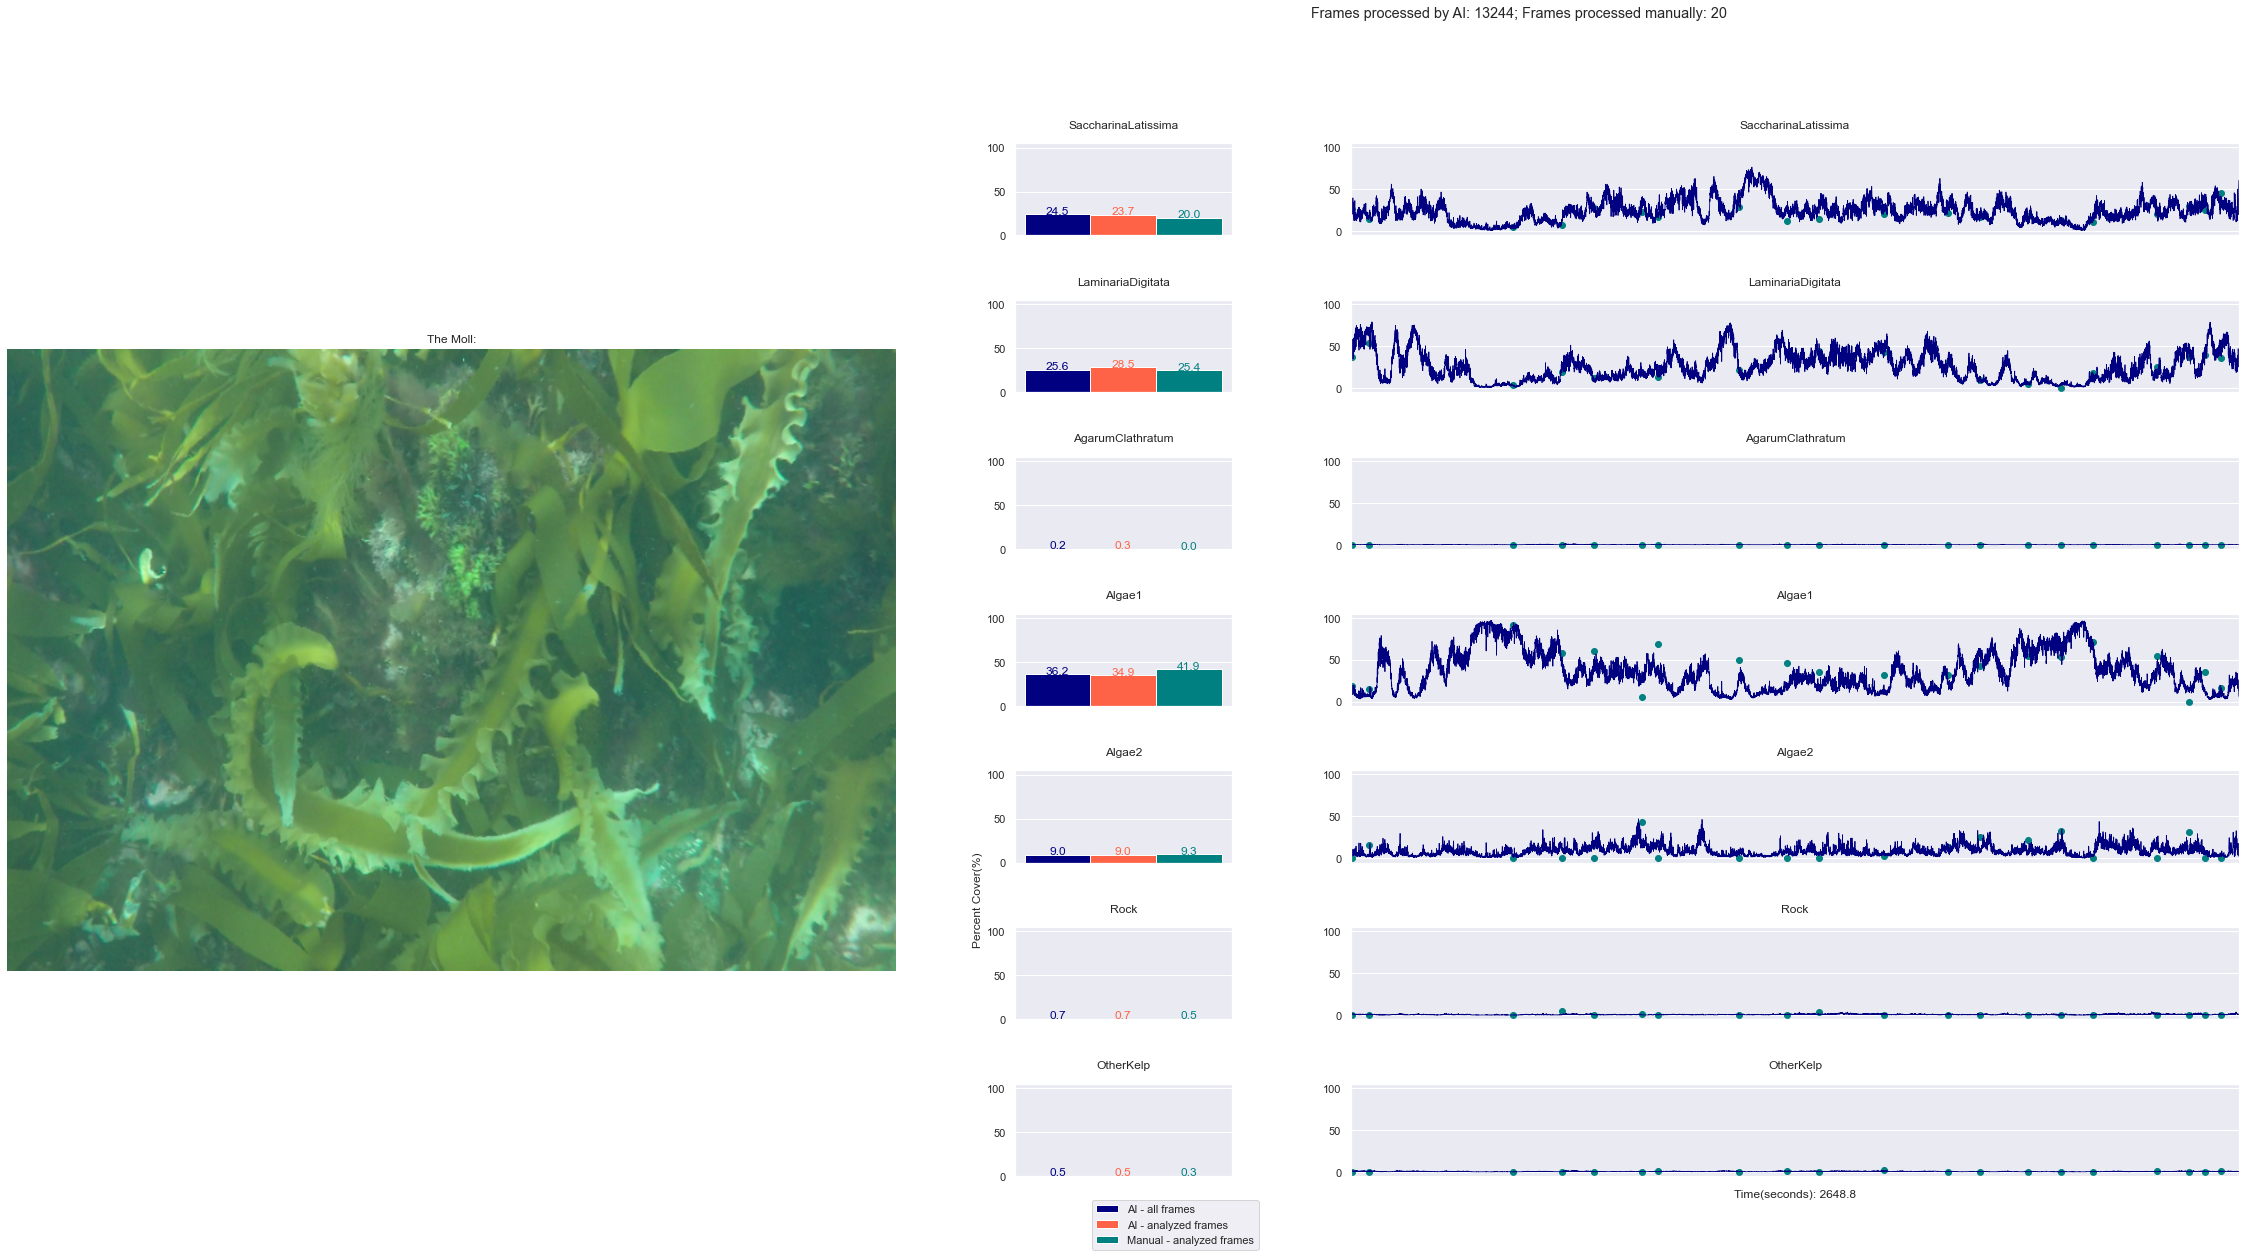

In [7]:
length_line = len(test_labels) * 0.2 # Each frame will plot every 0.2 second
 
# xax_time = [i for i in range(0.2,length_line, 20)]
xax_time = np.arange(0.2, length_line, 30) #Arranging the xticks starting from 0.2 till the length with 30 steps

f2 = plt.figure(figsize = (40, 19)) #Creating figure
grid = plt.GridSpec(7, 7, wspace =0.55, hspace = 0.7) #Creating grid inside that figure with 7 row and 7 column
xax = [' AI: all frames', 'AI: analyzed frames', 'Manual: analyzed frames']
X_axis = np.arange(3) #X axis for bar chart
g1 = plt.subplot(grid[0:7, 0:3]) # First grid for showing video utilizing first 3 columns

# 4th column for barcharts
g2 = plt.subplot(grid[0, 3])
g3 = plt.subplot(grid[1, 3])
g4 = plt.subplot(grid[2, 3])
g5 = plt.subplot(grid[3, 3])
g6 = plt.subplot(grid[4, 3])
g7 = plt.subplot(grid[5, 3])
g8 = plt.subplot(grid[6, 3])

#last 3 columns for time line chart
g9 = plt.subplot(grid[0, 4:])
g10 = plt.subplot(grid[1, 4:])
g11= plt.subplot(grid[2, 4:])
g12 = plt.subplot(grid[3, 4:])
g13 = plt.subplot(grid[4, 4:])
g14 = plt.subplot(grid[5, 4:])
g15 = plt.subplot(grid[6, 4:])

subs = [g2, g3, g4, g5, g6, g7, g8] #All bar charts
subs2 = [g9, g10, g11, g12, g13, g14, g15] #All line charts
f2.canvas.draw()
# plt.subplot_tool()

sum_cumul = [0.0,0.0,0.0,0.0,0.0,0.0,0.0] #Cumulative sum of all predictions
sum_cumul_analyzed = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
sum_cumul_manual = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
cumul_analyzed = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
cumul_manual = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]

sl = []
ld=[]
ac=[]
a1 = []
a2 = []
rock = []
ok=[]
frames_list = []

sl_manual = []
ld_manual = []
ac_manual = []
a1_manual = []
a2_manual = []
rock_manual = []
ok_manual = []
analyz_frames = []
manual_list=[[],[],[],[],[],[],[]]
seconds = 0.2
count=0
video_name = 'moll_mobilenet_30.avi' 
video = cv2.VideoWriter(video_name, 0, 5.0, (2880, 1368)) #Creating Video writee to save video

sns.set()
for ind, (i,j) in enumerate(zip(test_image, test_labels)): #Iterating over every image and labels
    X1 = np.array(i, dtype='float32') #Converting it into numpy array
    y = np.array(j, dtype='float32') #Converting labels into numpy array
    X = X1 / 255.0 #Normalizing it

    classes = np.array(['SaccharinaLatissima', 'LaminariaDigitata', 'AgarumClathratum', 'Algae1', 'Algae2', 'Rock', 'OtherKelp'])
    proba = model.predict(X.reshape(1, 456, 811, 3)) #Predicting the current frame
    pred = list(proba[0])
    pred = [v for indx,v in enumerate(pred) if indx!=6] # removing 'Unknown' label

    #Appending predictions to their corresponding lists in percentage
    sl.append(pred[0]*100)
    ld.append(pred[1]*100)
    ac.append(pred[2]*100)
    a1.append(pred[3]*100)
    a2.append(pred[4]*100)
    rock.append(pred[5]*100)
    ok.append(pred[6]*100)
    # frames_list.append(ind+1)
    frames_list.append(seconds) #Adding seconds for X-axis

    # print(frames_list)
    pred_list = [sl, ld, ac, a1, a2, rock, ok] #List of predictions

    list1 = [pred, sum_cumul]
    sum_cumul = [round(sum(k),3) for k in zip(*list1)] #Summing the predictions with sum_cumul
    cumul = [round(l/(ind+1), 3) for l in sum_cumul] #Getting average value of predictions from the start of the video till end

    #Showing video with every frame 
    o = cv2.resize(i, (1000, 700))

    g1.clear()
    g1.axis('off')
    g1.set_title('The Moll:')
    g1.imshow(o)


    if(j!=0):# If j is not 0 which means the frame is analyzed one
        #Appending the analyzed labels to their corresponding lists in percentage
        dist = [v for indx,v in enumerate(j) if indx!=6]
        sl_manual.append(dist[0]*100)
        ld_manual.append(dist[1]*100)
        ac_manual.append(dist[2]*100)
        a1_manual.append(dist[3]*100)
        a2_manual.append(dist[4]*100)
        rock_manual.append(dist[5]*100)
        ok_manual.append(dist[6]*100)
        manual_list = [sl_manual, ld_manual, ac_manual, a1_manual, a2_manual, rock_manual, ok_manual] #List of analyzed labels for image

        count+=1 #Count the number of analyzed frames
        # analyz_frames.append(ind+1)
        analyz_frames.append(seconds) #Adding seconds to list for scatter plot of manually analyzed frames

        #Cumulative prediction of analyzed frames from model from beginning of the video for barchart
        list3 = [pred, sum_cumul_analyzed]
        sum_cumul_analyzed = [round(sum(o),3) for o in zip(*list3)]
        cumul_analyzed = [round(p/count, 3) for p in sum_cumul_analyzed]

        #Cumulative value of manually analyzed frame for barchart
        list2 = [dist, sum_cumul_manual]
        sum_cumul_manual = [round(sum(m),3) for m in zip(*list2)]
        cumul_manual = [round(n/count, 3) for n in sum_cumul_manual]

    frames = ind + 1 # Count number of frames processed


    for label2, (sub2,cl2,p,m) in enumerate(zip(subs2, classes, pred_list, manual_list)): #Iterate over grid for line chart, classes, list of predictions and list of manually analyzed labels

        sub2.clear()
        sub2.plot(frames_list, p, c='navy', label='AI Interpretation', linewidth=0.8)
        sub2.scatter(analyz_frames, m, c='teal', label='Manual Interpretation')
        # sub2.set_ylabel("% Cover of "+ cl2)
        sub2.set_ylim([-5,105])
        sub2.set_title(cl2, y=1.1)
        # sub2.set_yticks([])
        sub2.grid(axis='x')
        sub2.set_xticks(xax_time, labels=[])
        sub2.set_xlim([0.2, 2650])

    sub2.set_xlabel('Time(seconds): ' + str(seconds))

    for label, (sub,cl) in enumerate(zip(subs, classes)): # Iterating over grids to plot bar chart

        sub.clear()

        sub.bar(0, cumul[label]*100, 1,  color='navy', label='AI - all frames')
        sub.bar(1, cumul_analyzed[label]*100, 1, color='tomato', label='AI - analyzed frames')
        sub.bar(2, cumul_manual[label]*100, 1, color='teal', label='Manual - analyzed frames')


        sub.set_ylim([0,105])
        sub.set_title(cl, y=1.1)
        # sub.grid(False)
        sub.set_xticks([])
        #To add text for cumulative percentage  over each bar chart
        sub.text(0, cumul[label]*100+0.2, str(round(cumul[label]*100, 2)), horizontalalignment='center', color='navy')
        sub.text(1, cumul_analyzed[label]*100+0.2, str(round(cumul_analyzed[label]*100, 2)), horizontalalignment='center', color='tomato')
        sub.text(2, cumul_manual[label]*100+0.2, str(round(cumul_manual[label]*100, 2)), horizontalalignment='center', color='teal')

    sub.set_ylabel('Percent Cover(%)', y=3)
    sub.legend(bbox_to_anchor=(1.15, -0.2))

    seconds = round(seconds+0.2,1) #Increasing seconds every 0.2 seconds 
    f2.suptitle('Frames processed by AI: '+str(frames) +"; Frames processed manually: "+str(count), x=0.65)



    f2.canvas.draw()
    #Converting matplotlib canvas to opencv image for writing it to the video
    img = np.frombuffer(f2.canvas.tostring_rgb(), dtype=np.uint8)
    img  = img.reshape(f2.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)



    cv2.imshow('frames', img)


    video.write(img)

    k = cv2.waitKey(33) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()
video.release()

In [ ]:
import os, ffmpeg
def compress_video(video_full_path, output_file_name, target_size): #Algorithm to compress the video size

    probe = ffmpeg.probe(video_full_path)
    duration = float(probe['format']['duration'])

    target_total_bitrate = (target_size * 1024 * 8) / (1.073741824 * duration)


    video_bitrate = target_total_bitrate

    i = ffmpeg.input(video_full_path)
    ffmpeg.output(i, os.devnull,
                  **{'c:v': 'libx264', 'b:v': video_bitrate, 'pass': 1, 'f': 'mp4'}
                  ).overwrite_output().run()
    ffmpeg.output(i, output_file_name,
                  **{'c:v': 'libx264', 'b:v': video_bitrate, 'pass': 2, 'c:a': 'aac'}
                  ).overwrite_output().run()

compress_video('moll_mobilenet_30.avi', 'moll_mobilenet30_compressed.avi', 1000000) #Input video, Target video and the size to save video in kb